### Imports

In [1]:
import numpy as np
from specmf.models import Graph, MultiFidelityModel
from specmf.utils import error_analysis, load_model_config
from specmf.data import load_data
from specmf.plot import *

In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>

#### Data loading

In [3]:
dataset_name = "cavity-flow"

x_LF, x_HF = load_data(
    dataset_name,
    preprocess=True,
    normalize=False, 
    flatten=True,
)

print(f"{x_LF.shape=}", f"{x_HF.shape=}")

Loading cavity flow data ...
x_LF.shape=(9094, 221) x_HF.shape=(9094, 221)


### Plot data 

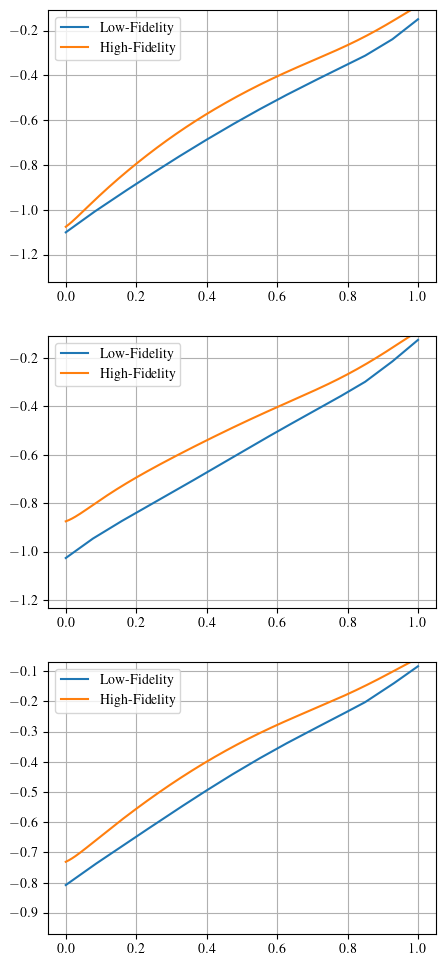

In [4]:
plot_data(x_LF, x_HF, dataset_name, n_samples=3)

### Multi-fidelity model

#### Create graph and model instances

In [5]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}

g_LF = Graph(data=x_LF, **graph_config)

#### Perform spectral clustering

In [6]:
n_HF = 100
inds_train, labels = g_LF.cluster(n_HF)

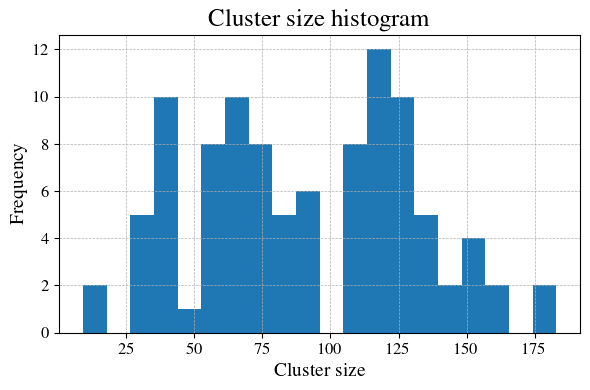

In [7]:
plot_cluster_size_hist(labels)

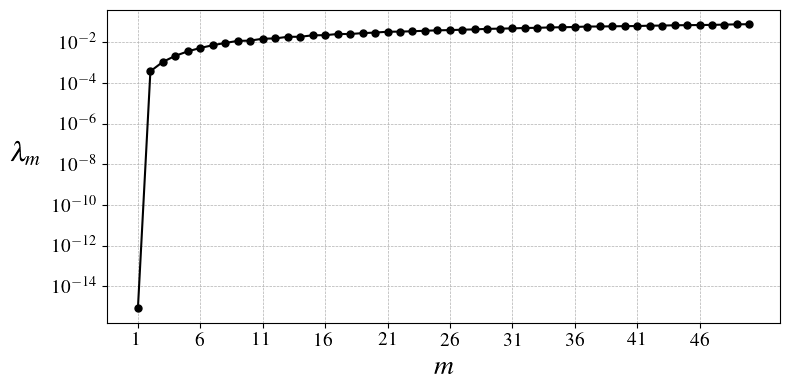

In [8]:
# Plot Laplacian spectrum
eigvals, eigvecs = g_LF.laplacian_eig()
plot_spectrum(eigvals, 50)

#### Split high-fidelity data

In [9]:
n_samples = x_HF.shape[0]
inds_test = np.delete(np.arange(n_samples), inds_train)
x_HF_train = x_HF[inds_train, :]
x_HF_test = x_HF[inds_test, :]

print(f"{x_HF_train.shape=}", f"{x_HF_test.shape=}")

x_HF_train.shape=(100, 221) x_HF_test.shape=(8994, 221)


#### Fit and train the model

In [10]:
fit_model = True

# Create the model 
model_config = {
    'sigma': 0.01,
    'method': 'full'
}
model = MultiFidelityModel(**model_config)

Model Configuration:
sigma              : 0.01
beta               : 2
kappa              : 0.0003943534199057717
omega              : 2841.4321681019824
method             : full
spectrum_cutoff    : None
tau                : 0.0003725410714697166


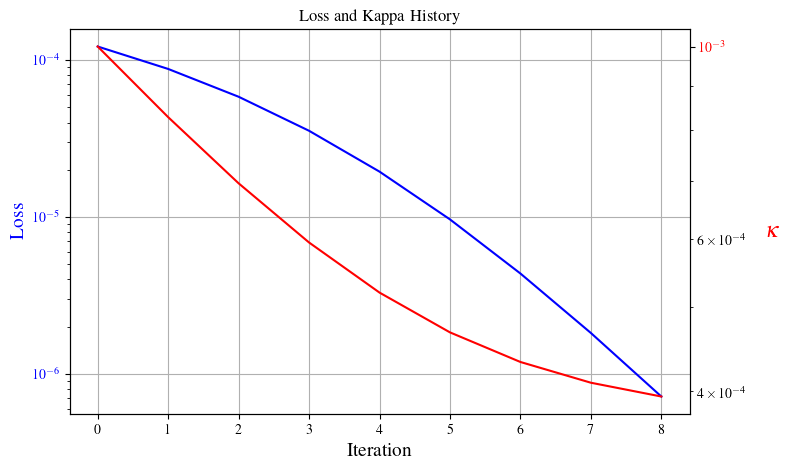

In [11]:
if fit_model:
    x_MF, C_phi, dPhi, loss_history, kappa_history = model.fit_transform(
        g_LF,
        x_HF_train,
        inds_train,
        maxiter=10,
        step_size=1e3,
        step_decay_rate=1.0,
        ftol=1e-6,
        gtol=1e-8,
        verbose=False,
    )
    model.summary()

    plot_loss_and_kappa(loss_history, kappa_history)

else:
    from pathlib import Path

    notebook_path = Path.cwd()
    yaml_file_path = notebook_path.parent.parent / 'data/model_configs.yaml'
    model_config = load_model_config(yaml_file_path, dataset_name)
    
    model = MultiFidelityModel(**model_config)

    x_MF, C_phi, dPhi = model.transform(g_LF, x_HF_train, inds_train)
    model.summary()

Text(0.5, 1.0, 'Variance histogram Cavity data')

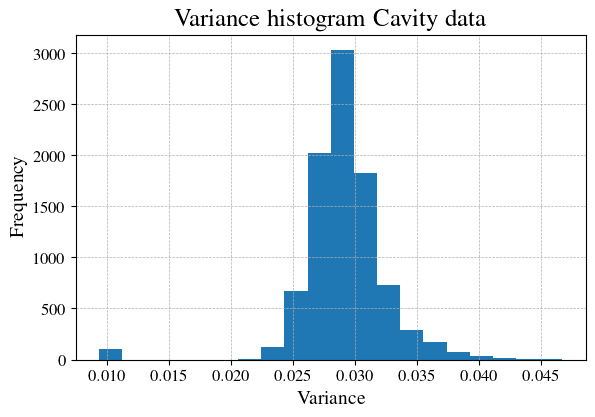

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(dPhi, bins=20)
ax.set_xlabel("Variance", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
ax.tick_params(axis="both", labelsize=12)
ax.set_title("Variance histogram Cavity data", fontsize=18)

### Results

In [13]:
# Error Analysis for unseen test datadet
error_analysis(x_LF[inds_test], x_MF[inds_test], x_HF_test)

Mean relative L2 errors and percentage error drop
-------------------------------------------------
Error LF:  18.63
Error MF:  3.91
[%] drop:  78.99


In [14]:
# Error Analysis for the whole dataset
error_analysis(x_LF, x_MF, x_HF)

Mean relative L2 errors and percentage error drop
-------------------------------------------------
Error LF:  18.63
Error MF:  3.87
[%] drop:  79.2


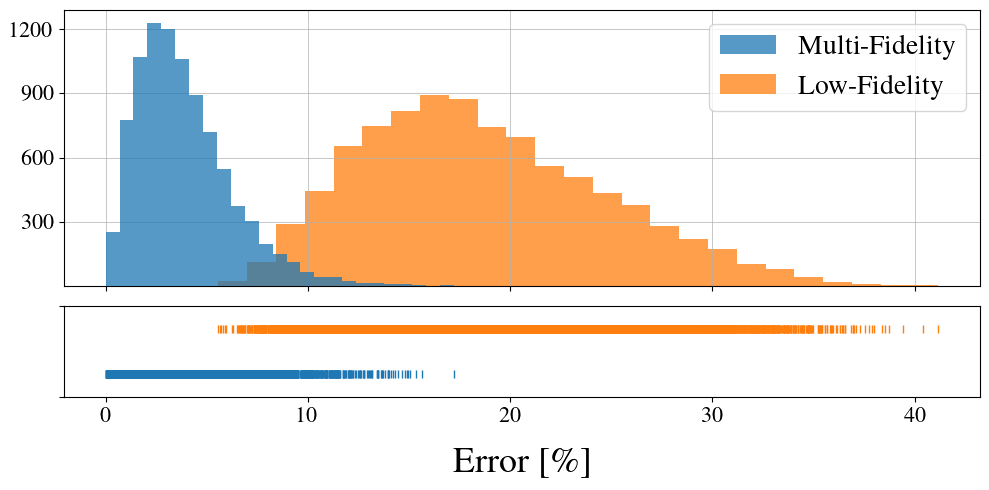

In [15]:
E_LF = 100 * np.linalg.norm(x_LF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)
E_MF = 100 * np.linalg.norm(x_MF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)

plot_distributions(E_LF, E_MF, bins_LF=25, bins_MF=25, mask=None)

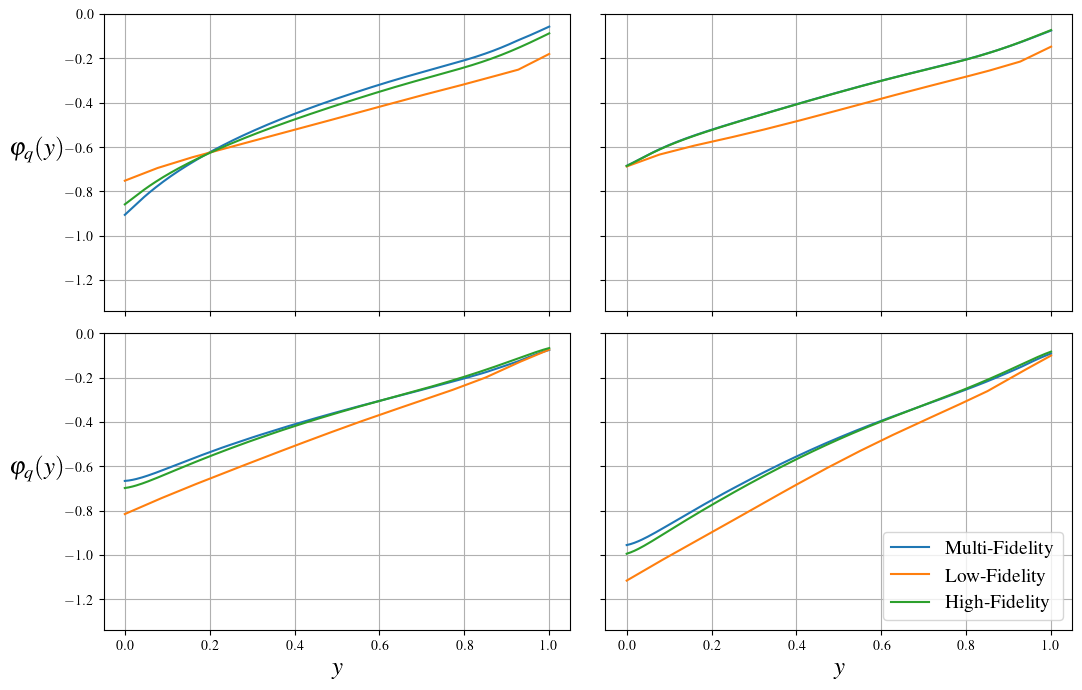

In [16]:
x_values = np.linspace(0, 1, x_LF.shape[1])
ylabel = r"$\varphi_{q}(y)$"
xlabel = r"$y$"
ymax = 0.
samples = [2686, 233, 2374, 2272]  # [6371, 1726, 5791, 8073]

plot_mf_comparison(
    dataset_name=dataset_name,
    X_LF=x_LF,
    X_MF=x_MF,
    X_HF=x_HF,
    samples=samples,
    x_values=x_values,
    xlabel=xlabel,
    ylabel=ylabel,
    ymax=ymax,
)


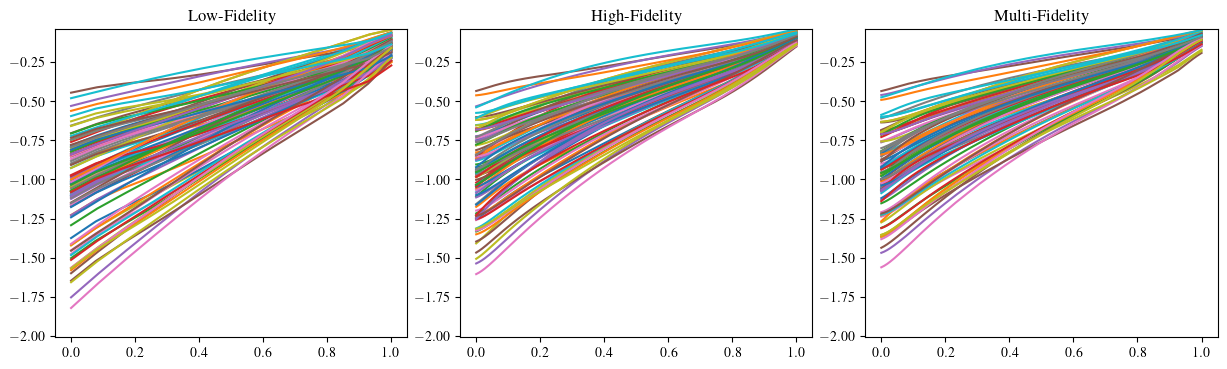

In [17]:
n_points, _ = x_LF.shape
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.15)
vmin, vmax = 1 * np.min((x_LF, x_HF)), 1.2 * np.max((x_LF, x_HF))
for i in range(100):
    j = np.random.randint(0, n_points)
    x_ = np.linspace(0, 1, x_LF[j, :].shape[0])
    axs[0].plot(x_, x_LF[j, :], label="Low-Fidelity")
    axs[0].set_title("Low-Fidelity")
    axs[1].plot(x_, x_HF[j, :], label="High-Fidelity")
    axs[1].set_title("High-Fidelity")
    axs[2].plot(x_, x_MF[j, :], label="Multi-Fidelity")
    axs[2].set_title("Multi-Fidelity")
    axs[0].set_ylim((vmin, vmax))
    axs[1].set_ylim((vmin, vmax))
    axs[2].set_ylim((vmin, vmax))

### Visualize uncertainty of multi-fidelity estimates

In [18]:
import matplotlib.ticker as ticker

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [19]:
_, eigevs = g_LF.laplacian_eig()
X = np.real(eigvecs[:, :n_HF])

In [20]:
import umap

X_umap = umap.UMAP(
    n_components=2,
    n_neighbors=50,
    min_dist=1,
    # metric="precomputed",
    init='random', 
    random_state=42
).fit_transform(X)

/opt/homebrew/Caskroom/miniforge/base/envs/generic-env/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'UMAP of Cavity Flow data (Case 5)')

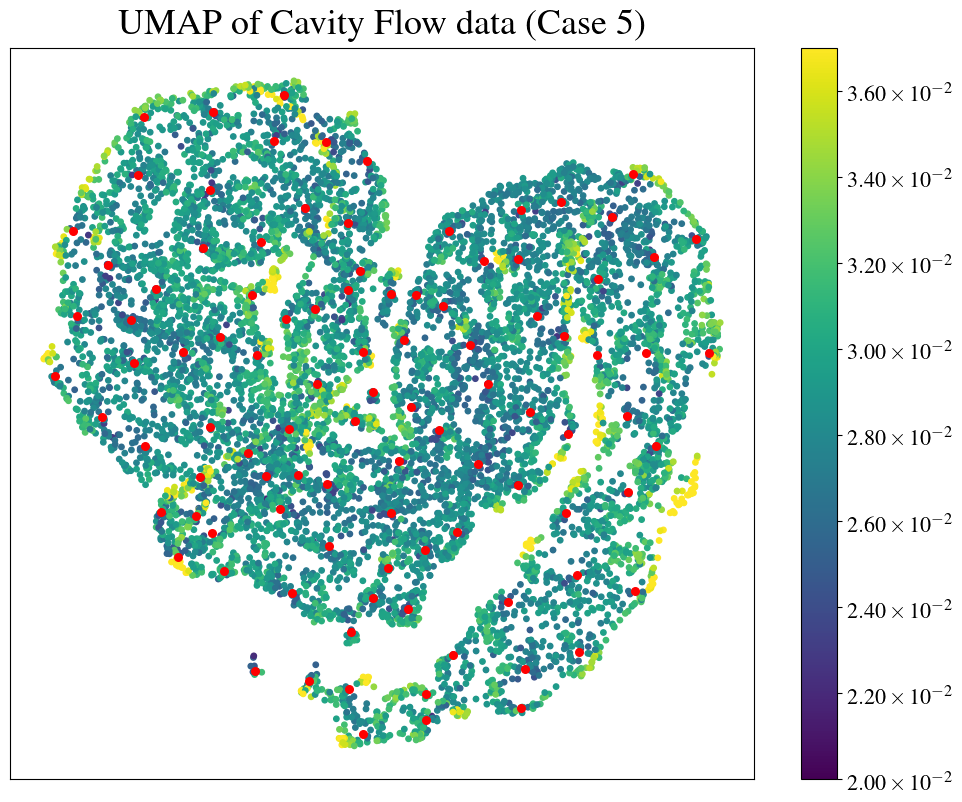

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9.5))
ax1 = ax.scatter(X_umap[:, 0], X_umap[:, 1], s=15, c=dPhi, vmin=0.02, vmax=0.037)
ax.scatter(X_umap[inds_train, 0], X_umap[inds_train, 1], s=30, c='r', marker='o')
cb = plt.colorbar(ax1, format=ticker.FuncFormatter(fmt))
cb.ax.tick_params(labelsize=16)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of Cavity Flow data (Case 5)', fontsize=26, pad=10)